In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import torch
from umap import UMAP

import pancancer_evaluation.config as cfg
from csd_simulations import simulate_csd
from fit_models import fit_k_folds_csd

np.random.seed(42)
torch.manual_seed(42)

%load_ext autoreload
%autoreload 2

### Simulate data from multiple "domains"

Main simulation code is in `09_simulations/csd_simulations.py`.

In [2]:
# see 09_simulations/csd_simulations.py for details on simulation parameters
n_domains = 5
n_per_domain = 50
p = 20
k = 5
k_up_to = 6

corr_top, diag = 1, None
# corr_top, diag = 0.5, 5
# corr_top, diag = 0.1, 10

# location to save plots to
output_plots = True
sim_results_dir = cfg.repo_root / '09_simulations' / 'simulation_results' / 'simulate_k'
output_plots_dir = cfg.repo_root / '09_simulations' / 'simulation_plots' / 'simulate_k'

In [3]:
xs, ys = simulate_csd(n_domains, n_per_domain, p, k, 
                      corr_noise=True,
                      corr_top=corr_top,
                      diag=diag)

print(xs.shape)
print(xs[:5, :5])

(250, 20)
[[ 1.28828102 -0.8085964  -0.45043737  2.14735295 -3.2518469 ]
 [ 1.01378829 -4.0306337  -2.99138792  2.93119506 -4.82641655]
 [ 1.88286051 -5.24705024 -0.13954148  2.79446203 -3.62264743]
 [ 2.49753911 -1.61833458 -4.86647454  4.11383995 -4.74531711]
 [ 0.91061687 -4.53663677 -3.79499793  2.56645773 -3.93350473]]


In [4]:
print(ys.shape)
print(ys[:3, :])

(250, 1)
[[ 1]
 [ 1]
 [-1]]


### Plot simulated data

We'll do this using both PCA and UMAP, side by side. We can color by domain and use different shapes for each label, to get an idea of how data clusters with respect to domain and how separable we expect different labels to be across domains.

In [5]:
pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(xs)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(xs)

domains = np.concatenate([([i] * n_per_domain) for i in range(n_domains)])

X_pca_df = pd.DataFrame(X_proj_pca,
                        columns=['PC{}'.format(j) for j in range(X_proj_pca.shape[1])])
X_pca_df['domain'] = domains
X_pca_df['label'] = ys.flatten()

X_umap_df = pd.DataFrame(X_proj_umap,
                        columns=['UMAP{}'.format(j) for j in range(X_proj_umap.shape[1])])
X_umap_df['domain'] = domains
X_umap_df['label'] = ys.flatten()

X_umap_df.head()

,UMAP0,UMAP1,domain,label
0,10.440638,-6.210529,0,1
1,10.231043,-6.616573,0,1
2,9.990054,-7.128282,0,-1
3,9.851095,-7.610100,0,-1
4,9.575669,-7.595281,0,-1


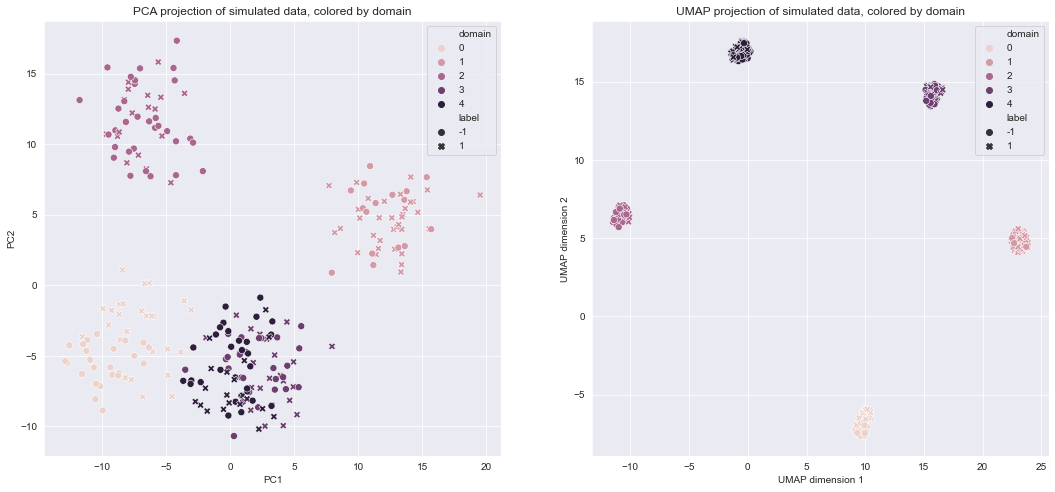

In [6]:
sns.set({'figure.figsize': (18, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue='domain', style='label', s=50, ax=axarr[0])
sns.scatterplot(data=X_umap_df, x='UMAP0', y='UMAP1', hue='domain', style='label', s=50, ax=axarr[1])
    
axarr[0].set_title('PCA projection of simulated data, colored by domain')
axarr[0].set_xlabel('PC1')
axarr[0].set_ylabel('PC2')
axarr[0].legend()
axarr[1].set_title('UMAP projection of simulated data, colored by domain')
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].legend()

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(
        output_plots_dir / 'n{}_p{}_k{}_corr{}_scale{}_pca_umap.png'.format(
            n_domains, p, k, corr_top, diag),
    dpi=200, bbox_inches='tight')

### Fit models with varying (fixed) k

TODO: explain

In [7]:
results_df = fit_k_folds_csd(xs, ys, domains[:, np.newaxis], k_up_to)
results_df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

,k_model,fold,metric,value
0,1,0,train_auroc,0.808608
1,2,0,train_auroc,0.645147
2,3,0,train_auroc,0.792353
3,4,0,train_auroc,0.731113
4,5,0,train_auroc,0.693109


(-0.1, 1.1)

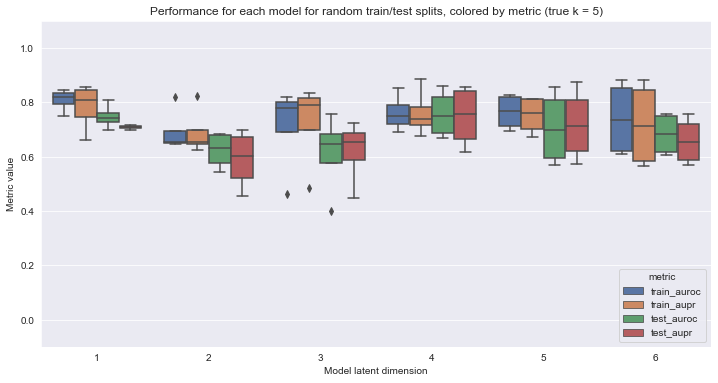

In [8]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(
    data=results_df.sort_values(by=['k_model'])
                   .sort_values(by=['metric'], ascending=False),
    x='k_model', y='value', hue='metric'
)
plt.title(
    'Performance for each model for random train/test splits, colored by metric (true k = {})'
    .format(k)
)
plt.xlabel('Model latent dimension')
plt.ylabel('Metric value')
plt.ylim(-0.1, 1.1)

# if output_plots:
#     plt.savefig(
#         output_plots_dir / 'n{}_p{}_k{}_corr{}_scale{}_random_perf.png'.format(
#             n_domains, p, k, corr_top, diag),
#     dpi=200, bbox_inches='tight')